# Exercise 5: NENGO model of Raven's progressive matrices

Please complete this assignment **in pairs**.

Name of student 1: Brian

Name of student 2: `YOU, THE OTHER YOU, YEAH YOU, YOUR NAME HERE`

Let's start by installing the required libraries.

In [1]:
%pip install nengo nengo-spa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.3/542.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 4.4 MB/s eta 0:00:00


Now let's import libraries and set the parameters. I used a dimensionality of 256, but if you want the model to run faster, use a smaller dimensionality. With larger dimensionalities, you get better accuracy and more reliable results.

In [2]:
#@title Import Libraries and Set Parameters (Provided)

%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 42
rng = np.random.RandomState(seed + 1)
dim = 128

Next define the vocabularies. You'll need at least one vocabulary. I used three vocabularies. The first for the atomic elements (e.g., square, black, three, left, right, centre) of a Raven matrix pattern. The second for the 8 known cells of the Raven Matrix. The third for the 8 possible answers to select from. Convert between vocabularies using spa.reintrepret() from the Vocabulary Casting tutorial.

# Part 1: Creating Your NENGO Model

In [3]:
#@title Define Semantic Pointer Vocabularies (COMPLETE THIS)

# declare a vocabulary, check the intro tutorial on how to do this
# I used 3 vocabularies, this first vocabulary is for atomic elements
# use .populate() to define all the shapes, colours, numbers, tilts/orientations

# the atomic-element vocabulary
atom_vocab = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
atom_vocab.populate(";".join([
    # variables
    "SHAPE1;SHAPE2;NUMBER1;NUMBER2;DIRECTION;COLOUR",
    # type of shapes
    "CIRCLE;SQUARE;TRIANGLE;DIAMOND",
    # number of shapes
    "ONE;TWO;THREE;FOUR;FIVE;SIX",
    # direction of triangles
    "LEFT;RIGHT;STRAIGHT",
    # colour
    "GREY;WHITE"
]))

# then define a nested list as follows:
# raven = [["a","b","c"],["d","e","f"],["g","h"]]

raven = [
    ["SHAPE1*CIRCLE + NUMBER1*ONE",
        "SHAPE1*CIRCLE + NUMBER1*TWO",
        "SHAPE1*CIRCLE + NUMBER1*THREE"],
    ["SHAPE1*SQUARE + NUMBER1*ONE",
        "SHAPE1*SQUARE + NUMBER1*TWO",
        "SHAPE1*SQUARE + NUMBER1*THREE"],
    ["SHAPE1*TRIANGLE + NUMBER1*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*TWO"],
]

raven2 = [
    ["SHAPE1*TRIANGLE + NUMBER1*ONE + DIRECTION*STRAIGHT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*TWO + DIRECTION*STRAIGHT + COLOUR*GREY + SHAPE2*SQUARE + NUMBER2*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*STRAIGHT + COLOUR*GREY + SHAPE2*DIAMOND + NUMBER2*ONE"],
    ["SHAPE1*TRIANGLE + NUMBER1*ONE + DIRECTION*RIGHT + COLOUR*GREY + SHAPE2*DIAMOND + NUMBER2*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*TWO + DIRECTION*RIGHT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*RIGHT + COLOUR*GREY + SHAPE2*SQUARE + NUMBER2*ONE"],
    ["SHAPE1*TRIANGLE + NUMBER1*ONE + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*SQUARE + NUMBER2*ONE",
        "SHAPE1*TRIANGLE + NUMBER1*TWO + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*DIAMOND + NUMBER2*ONE"],
]

# replace each of the letters above with a string describing the cell
# use the vocabulary you defined for the atomic elements and combine elements
# using the now familiar HRR operators of + for addition, * for convolution
# and ~ for inverse (recall ~a*a*b = b)
# optional: you can add the solution in as the last element "i" if you want
# just don't use the solution during training

# Here, provided for you, I construct a second vocabulary of the cells of the Raven's matrix
# I loop over the rows and columns of `raven`
# then add each element of raven to the vocabulary.
rvn_vocab = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
for i in range(3):
    for j in range(3):
        if len(raven[i]) > j:
            rvn_vocab.add("Raven"+str(i)+str(j), spa.reinterpret(atom_vocab.parse(raven[i][j])))

rvn_vocab2 = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
for i in range(3):
    for j in range(3):
        if len(raven2[i]) > j:
            rvn_vocab2.add("Raven"+str(i)+str(j), spa.reinterpret(atom_vocab.parse(raven2[i][j])))

# lastly, we need to create the answers
# I would create two lists, one for the answer names
# (which can be as simple as Answer 1, Answer 2, Answer 3, ... Answer 8
# though I would mark the correct one as correct, e.g.,"Answer 1 (CORRECT)"

answer_names = [
    "Answer1_CORRECT",
    "Answer2",
    "Answer3",
    "Answer4",
    "Answer5",
    "Answer6",
    "Answer7",
    "Answer8",
]

answer_names2 = [
    "Answer1",
    "Answer2",
    "Answer3",
    "Answer4",
    "Answer5",
    "Answer6_CORRECT",
    "Answer7",
    "Answer8",
]

# Then create a second list of strings that defines each answer
# using the atomic elements and + * ~ operations,e.g."colour*black+shape*square"

answer_vectors = [
    "SHAPE1*TRIANGLE + NUMBER1*THREE", # correct
    "SHAPE1*TRIANGLE + NUMBER1*TWO",
    "SHAPE1*SQUARE + NUMBER1*THREE",
    "SHAPE1*TRIANGLE + NUMBER1*FIVE",
    "SHAPE1*TRIANGLE + NUMBER1*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*FOUR",
    "SHAPE1*SQUARE + NUMBER1*FOUR",
    "SHAPE1*SQUARE + NUMBER1*FIVE",
]

answer_vectors2 = [
    "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*DIAMOND + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*RIGHT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*TWO + DIRECTION*RIGHT + COLOUR*GREY + SHAPE2*SQUARE + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*FOUR + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*SQUARE + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*THREE + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE", # correct
    "SHAPE1*TRIANGLE + NUMBER1*TWO + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE",
    "SHAPE1*TRIANGLE + NUMBER1*ONE + DIRECTION*LEFT + COLOUR*GREY + SHAPE2*CIRCLE + NUMBER2*ONE"
]

# Once you have both you can loop over both lists
# e.g.,
# for name,vector in zip(answer_name,answer_vector):
# and then inside the loop use
# vobab3.add(name,spa.reintrepret(vobab1.parse(vector)))
# but with vocab3 and vocab1 swapped out for your vocabulary names

answer_vocab = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
for name, vec in zip(answer_names, answer_vectors):
    answer_vocab.add(name, spa.reinterpret(atom_vocab.parse(vec)))

answer_vocab2 = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
for name, vec in zip(answer_names2, answer_vectors2):
    answer_vocab2.add(name, spa.reinterpret(atom_vocab.parse(vec)))

I provide the following functions over time that provide the inputs into the model given a time in seconds (t). The model uses six inputs:
1. the previous (i.e., left) and
2. next cell (i.e., right) for the scan of the rows for the purpose of constructing the row transformation vector;
3. and the previous (i.e., up/adove) and
4. next cell (i.e., down/below) for the scan of the columns for the purpose of constructing the column transformation vector;
5. the cue for retrieving a prediction from the row transformation vector,
6. the cue for retrieving a prediction from the column transformation vector.


In [4]:
#@title Define Input Functions (provided)

# left / prev cell in row input function
    # given t, the function outputs a text string for a cell of the matrix
    # at different times, the input provides different cells of the matrix
    # I change the cell each 0.2 seconds
    # once the entire matrix has been studied, function outputs "0" in quotes
    # the output of "0" starts after 1 second
def left_input(t):
    interval = 0.2 # study each cell of the matrix for 0.2 seconds
    sequence = ["Raven00", "Raven01", "Raven10", "Raven11", "Raven20","0"]
    idx = min(int(t // interval),len(sequence)-1)
    return sequence[idx]

# right / next cell in row input function
    # same as the left function, but provides the cell to the right of it
def right_input(t):
    interval = 0.2 # study each cell of the matrix for 0.2 seconds
    sequence = ["Raven01", "Raven02", "Raven11", "Raven12", "Raven21","0"]
    idx = min(int(t // interval),len(sequence)-1)
    return sequence[idx]

# up/above or prev cell in column input function
    # same but for columns
def up_input(t):
    interval = 0.2 # study each cell of the matrix for 0.2 seconds
    sequence = ["Raven00", "Raven10", "Raven01", "Raven11", "Raven02","0"]
    idx = min(int(t // interval),len(sequence)-1)
    return sequence[idx]

# down/below or next cell in column input function
    # same but for columns
def down_input(t):
    interval = 0.2 # study each cell of the matrix for 0.2 seconds
    sequence = ["Raven10", "Raven20", "Raven11", "Raven21", "Raven12","0"]
    idx = min(int(t // interval),len(sequence)-1)
    return sequence[idx]

# the cue for eliciting a row production is a much simpler input function
def row_cue_input(t):
    if t < 1.0:
       return "0"
    return "Raven21"

# same deal for the cue that elicits the column production
    # except that the cue is the 2nd row 3rd column cell, which I call "Raven12"
def col_cue_input(t):
    if t < 1.0:
       return "0"
    return "Raven12"

In [5]:
#@title Create the NENGO Model (COMPLETE THIS)

from threading import ThreadError
with spa.Network("Raven Progressive Matrix Solver", seed=seed) as model:
    # create input buffers, populations of neurons
    # to hold the left, right, above/up, below/down inputs
    # i.e., the previous and next for rows and columns
    # and then two prediction cues, one for rows and one for columns
    # to do this use spa.Transcode on each of the input functions
    # and instead of specifying the vocab= the dimensionality
    # instead set vocab= the Raven matrix cells vocabulary you defined earlier
    left_in = spa.Transcode(left_input, output_vocab=rvn_vocab)
    right_in = spa.Transcode(right_input, output_vocab=rvn_vocab)
    up_in = spa.Transcode(up_input, output_vocab=rvn_vocab)
    down_in = spa.Transcode(down_input, output_vocab=rvn_vocab)

    # next define two buffers (neural populations) for holding
    # the row and column transformation vectors
    # just find the conv population from the Question Answering tutorial
    # copy and paste it here twice and give it a name for rows and columns

    # converts input into semantic pointer representations
    cue_row = spa.Transcode(row_cue_input, output_vocab=rvn_vocab)
    cue_col = spa.Transcode(col_cue_input, output_vocab=rvn_vocab)

    # create neural ensemble to hold and maintain semantic pointers
    conv_row = spa.State(vocab=rvn_vocab, subdimensions=16,
                         feedback=1.0, feedback_synapse=0.4)
    conv_col = spa.State(vocab=rvn_vocab, subdimensions=16,
                         feedback=1.0, feedback_synapse=0.4)

    # define an output population for holding the initial prediction
    # you can copy and paste 'out' from Question Answering
    # but change it to use the Raven's matrix cell vocabulary as above
    out = spa.State(vocab=rvn_vocab)

    # next drop in a Winner Take All associative memory
    # see the Associatve Memory tutorial
    model.assocmem = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=rvn_vocab,
        mapping=rvn_vocab.keys(),
        function=lambda x: x * 1.0,)

    # second last but not least, connect these populations together
    # using the >> operator in accordance with the model as
    # described in the Rasussen and Eliasmith pager
    # Don't forget you can use ~ * + to combine the contents of buffers

    # Learn / represent row transform: right ≈ left * ROW_TRANS
    (right_in * ~left_in) >> conv_row

    # Learn / represent column transform: down ≈ up * COL_TRANS
    (down_in * ~up_in) >> conv_col

    # Apply transforms to neighbours of the missing cell, cued by row/col cues
    # Row-based hypothesis: (row_cue cell) * row_conv
    (cue_row * conv_row) >> out

    # Column-based hypothesis: (col_cue cell) * col_conv
    (cue_col * conv_col) >> out

    # Feed hypothesis into WTA memory to select one of the 8 answers
    out >> model.assocmem

    # Lastly, get data for displaying results
    # Personally, I decided to collect data from
    # the four input buffers that scan the Raven's matrix
    # and most importantly the output of the Winner Take All memory
    # this should take the form of
    # give the data some name = nengo.Probe(neural population name.output)
    # Check the Question Answering and Associative Memory tutorial for examples

    with model:
        # lowpass filter of 30ms for all probes recording data during simulation
        model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)

        left_probe = nengo.Probe(left_in.output)
        right_probe = nengo.Probe(right_in.output)
        up_probe = nengo.Probe(up_in.output)
        down_probe  = nengo.Probe(down_in.output)

        cue_row_probe = nengo.Probe(cue_row.output)
        cue_col_probe = nengo.Probe(cue_col.output)

        conv_row_probe = nengo.Probe(conv_row.output)
        conv_col_probe = nengo.Probe(conv_col.output)

        out_probe = nengo.Probe(out.output)
        answer_probe = nengo.Probe(model.assocmem.output)

In [6]:
# @title Run the NENGO model (Provided)
run_time = 2.0 # run the model for 2.0 seconds
with nengo.Simulator(model) as sim:
    sim.run(run_time)

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nengo/cache.py", line 467, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.12/dist-packages/nengo/cache.py", line 389, in _load_index_file
    with self.index_path.open("rb") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/pathlib.py", line 1013, in open
    return io.open(self, mode, buffering, encoding, errors, newline)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [7]:
# @title Function for plotting the results (Provided)

def plot_similarities(
    t_range, input_list, input_labels, output_data, vocab1, vocab2=None, autoscale=False
):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -0.2, 5.0
    plt.figure(figsize=(12, 12))
    count = 1
    for input_data, label in zip(input_list,input_labels):
        # input data figures
        plt.subplot(3, 2, count)
        plt.ylim(ymin, ymax)
        if autoscale:
            plt.autoscale(autoscale, axis="y")
        plt.grid(True)
        plt.plot(t_range, spa.similarity(input_data, vocab1))
        plt.title(label + " similarity")
        plt.xlabel("Time")
        plt.xlim(right=t_range[-1])
        plt.legend(
            list(vocab1.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
        )
        count = count+1

    # output data figure
    plt.subplot(3, 2, count)
    plt.plot(t_range, spa.similarity(output_data, vocab2))
    plt.title("Output similarity")
    plt.xlabel("Time")
    plt.xlim(right=t_range[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis="y")
    plt.grid(True)
    plt.legend(
        list(vocab2.keys()), loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=3
    )
    plt.tight_layout()

The following code plots the input and output data of the network. The output is the important part.

**Change the names below to the names you used.**

I named my answer vocabulary `ans_vocab` and my Raven matrix vocabulary `rvn_vocab`. I named the probes `right_probe`, `left_probe`, `up_probe`, and `down_probe` for the 4 inputs during the scanning to construct the transformation vectors. The output from the winner-take-all memory I named `output_probe` and should provide the final prediction.

# Raven's Matrix, Figure 3

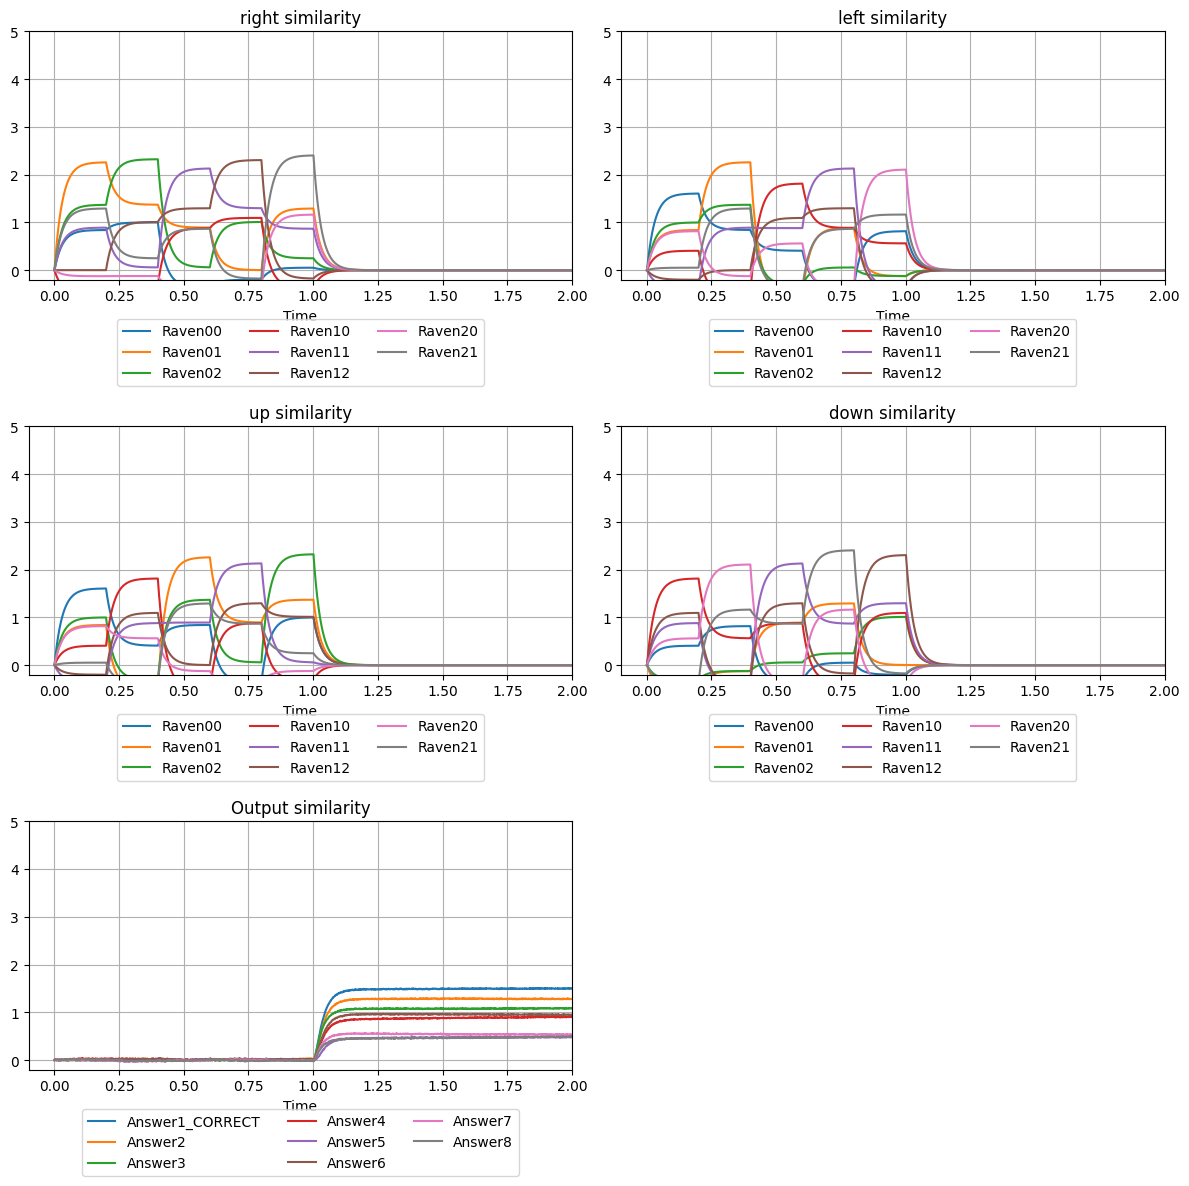

In [8]:
# @title Call the plotting function with the data from the network (MODIFY THIS)
# change the left_probe, right_probe, up_probe, down_probe names
# to match what you named the outputs from nengo.Probe earlier
# you can also change the input_labels
# and also change ans_vocab to whatever you named the vocabulary of answers
input_list =[sim.data[right_probe],
             sim.data[left_probe],
             sim.data[up_probe],
             sim.data[down_probe]]
input_labels=["right","left","up","down"]
plot_similarities(sim.trange(), input_list, input_labels, sim.data[out_probe], rvn_vocab, answer_vocab)

# Raven's Matrix Figure 1

In [9]:
from threading import ThreadError
with spa.Network("Raven Progressive Matrix Solver", seed=seed) as model2:
    # create input buffers, populations of neurons
    # to hold the left, right, above/up, below/down inputs
    # i.e., the previous and next for rows and columns
    # and then two prediction cues, one for rows and one for columns
    # to do this use spa.Transcode on each of the input functions
    # and instead of specifying the vocab= the dimensionality
    # instead set vocab= the Raven matrix cells vocabulary you defined earlier
    left_in = spa.Transcode(left_input, output_vocab=rvn_vocab2)
    right_in = spa.Transcode(right_input, output_vocab=rvn_vocab2)
    up_in = spa.Transcode(up_input, output_vocab=rvn_vocab2)
    down_in = spa.Transcode(down_input, output_vocab=rvn_vocab2)

    # next define two buffers (neural populations) for holding
    # the row and column transformation vectors
    # just find the conv population from the Question Answering tutorial
    # copy and paste it here twice and give it a name for rows and columns

    # converts input into semantic pointer representations
    cue_row = spa.Transcode(row_cue_input, output_vocab=rvn_vocab2)
    cue_col = spa.Transcode(col_cue_input, output_vocab=rvn_vocab2)

    # create neural ensemble to hold and maintain semantic pointers
    conv_row = spa.State(vocab=rvn_vocab2, subdimensions=16,
                         feedback=1.0, feedback_synapse=0.4)
    conv_col = spa.State(vocab=rvn_vocab2, subdimensions=16,
                         feedback=1.0, feedback_synapse=0.4)

    # define an output population for holding the initial prediction
    # you can copy and paste 'out' from Question Answering
    # but change it to use the Raven's matrix cell vocabulary as above
    out = spa.State(vocab=rvn_vocab2)

    # next drop in a Winner Take All associative memory
    # see the Associatve Memory tutorial
    model2.assocmem = spa.WTAAssocMem(
        threshold=0.15,
        input_vocab=rvn_vocab2,
        mapping=rvn_vocab2.keys(),
        function=lambda x: x * 1.0,)

    # second last but not least, connect these populations together
    # using the >> operator in accordance with the model as
    # described in the Rasussen and Eliasmith pager
    # Don't forget you can use ~ * + to combine the contents of buffers

    # Learn / represent row transform: right ≈ left * ROW_TRANS
    (right_in * ~left_in) >> conv_row

    # Learn / represent column transform: down ≈ up * COL_TRANS
    (down_in * ~up_in) >> conv_col

    # Apply transforms to neighbours of the missing cell, cued by row/col cues
    # Row-based hypothesis: (row_cue cell) * row_conv
    (cue_row * conv_row) >> out

    # Column-based hypothesis: (col_cue cell) * col_conv
    (cue_col * conv_col) >> out

    # Feed hypothesis into WTA memory to select one of the 8 answers
    out >> model2.assocmem

    # Lastly, get data for displaying results
    # Personally, I decided to collect data from
    # the four input buffers that scan the Raven's matrix
    # and most importantly the output of the Winner Take All memory
    # this should take the form of
    # give the data some name = nengo.Probe(neural population name.output)
    # Check the Question Answering and Associative Memory tutorial for examples

    with model2:
        # lowpass filter of 30ms for all probes recording data during simulation
        model2.config[nengo.Probe].synapse = nengo.Lowpass(0.03)

        left_probe = nengo.Probe(left_in.output)
        right_probe = nengo.Probe(right_in.output)
        up_probe = nengo.Probe(up_in.output)
        down_probe  = nengo.Probe(down_in.output)

        cue_row_probe = nengo.Probe(cue_row.output)
        cue_col_probe = nengo.Probe(cue_col.output)

        conv_row_probe = nengo.Probe(conv_row.output)
        conv_col_probe = nengo.Probe(conv_col.output)

        out_probe = nengo.Probe(out.output)
        answer_probe = nengo.Probe(model2.assocmem.output)

In [10]:
run_time = 2.0 # run the model for 2.0 seconds
with nengo.Simulator(model2) as sim:
    sim.run(run_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

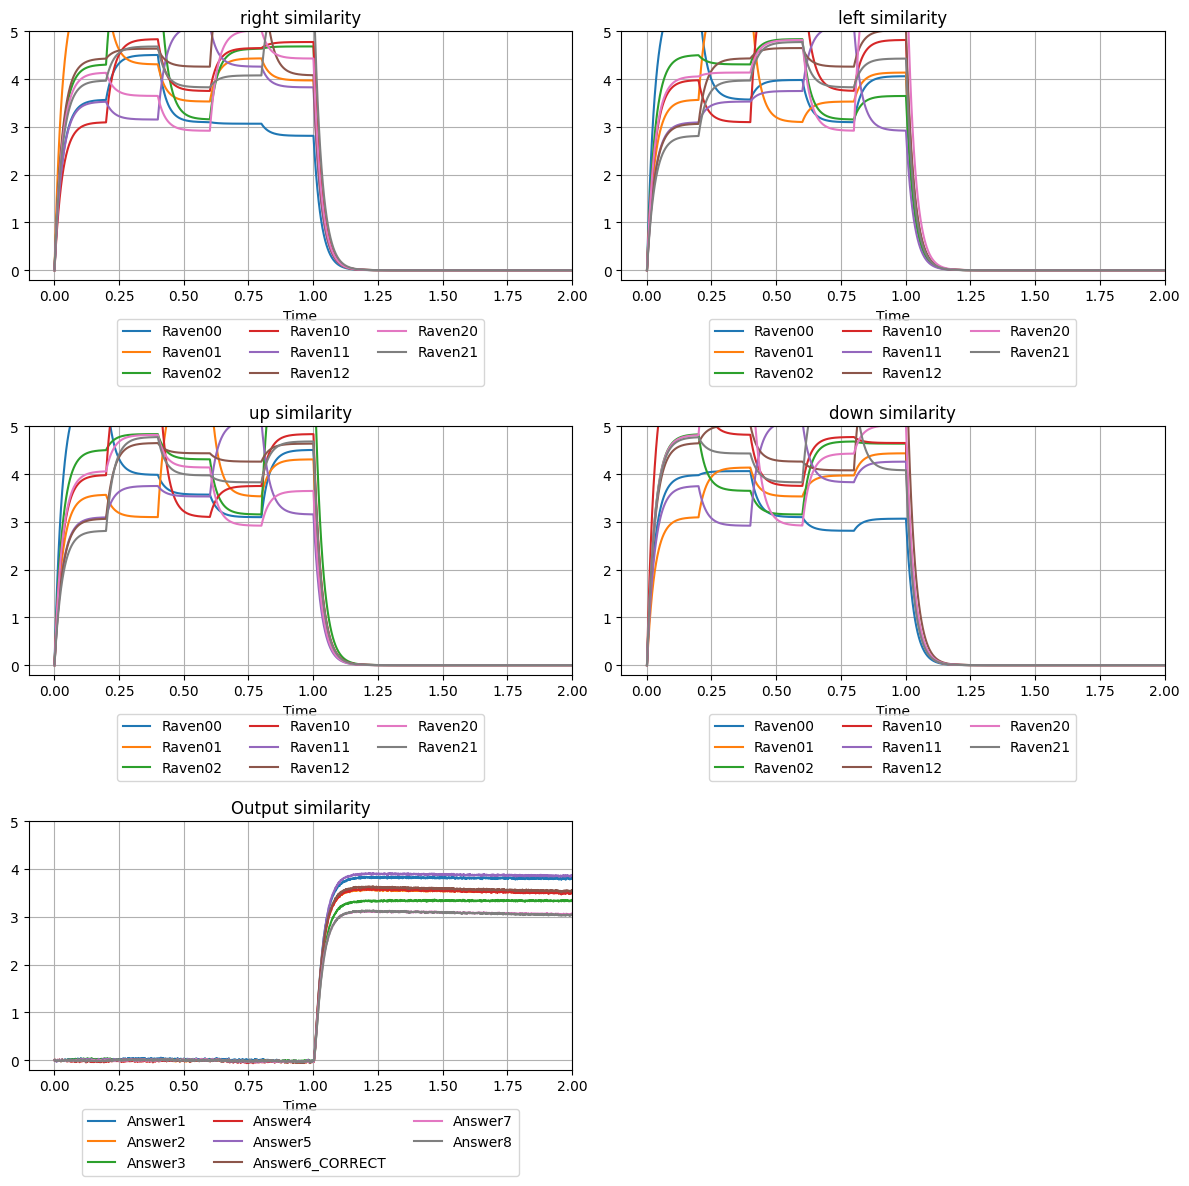

In [11]:
input_list =[sim.data[right_probe],
             sim.data[left_probe],
             sim.data[up_probe],
             sim.data[down_probe]]
input_labels=["right","left","up","down"]
plot_similarities(sim.trange(), input_list, input_labels, sim.data[out_probe], rvn_vocab2, answer_vocab2)

# Part 2: Evaluate Your NENGO Model

**Q 2.1. Run the NENGO model simulation you created above for Figure 3 of Rasmussen & Eliasmith 2011 using either the representations you used in Part 1 of Exercise 3 (if you found a way of representing Figure 3 that worked) or the representations discussed in class when the Exercise 3 answers were taken up. Does the NENGO model in this exercise produce the same behaviour as the HRR model from Exercise 3 Part 1? If not, are the differences due to a bug in your code, random chance, or some feature of NENGO?**

**(Hint: If you're seeing any big differences, it's a bug; if the differences go away on some simulation runs it's probably just random)**

# Raven's Matrix Figure 3

For the NENGO model simulation, the correct answer (Answer1 in blue) achieves the highest similarity, significantly higher than the second most similar answer (Answer3 in green).

Initially, the model was run with dimensionality of 128. At this level, Answer 1 was correctly chosen, however, the rest of the answers were close in similarity.

This is similar to exercise 3, when the HRR model also identified the correct answer of three triangle. With the HRR model, the similarity was also significantly greater. That output is shown below:

three triangles : cosine:  0.5591543712721817

two triangles : cosine:  0.4406766138552435

three squares : cosine:  0.39689350433560494

five triangles : cosine:  0.33072970837125676

one triange : cosine:  0.33151310773846077

four triangles : cosine:  0.31667596671077014

four squares : cosine:  0.15015772408804293

five squares : cosine:  0.16389554697567182


HYPOTHESIZED: three triangles
----------------------------------------

**Q 2.2. Run the simulation for Figure 1 of Rasmussen & Eliasmith 2011 by changing the Raven matrix vocabulary and the answer vocabulary (and the atomic vocabulary too if you need to). You can use # to comment out the previous vocabularies so you don't have to delete them. As before, either use your answer from Exercise 3 Part 2 or the "correct" answer taken up in class from Exercise 3 Part 2 (only use your answer if it worked in Exercise 3). Does the NENGO model in this exercise produce the same behaviour as the HRR model from Exercise 3 Part 2? If not, are the differences due to a bug, chance, or systematic differences with running models in NENGO?**

**(Hint: If you're seeing any big differences, it's a bug)**

I am not able to get the correct answer, and not able to debug the code to figure it out.

# Part 3: Understanding NENGO

**Q 3.1. Why is building a cognitive model in NENGO of interest to cognitive scientists? What do we gain by translating the Exercise 3 model, which represents the pattern completion process in holographic vectors, into the NENGO platform, which then represents the same model using spiking neurons? Justify your answer.**

Building cognitive models in NENGO is useful to allows researchers to test how cognitive ideas might actually work in the brain. With NENGO, math-based model using HRRs (Holographic Reduced Representations) can be translated into a network of simulated spiking neurons. This helps connect abstract theories to the real biology of the brain, to make testable predictions that simple math models cannot provide (Bekolay et al., 2014).

HRRs are high-dimensional vectors that allow the model to combine and retrieve information (superposition and binding), making them well suited for tasks like pattern-completion. In NENGO, these vectors are called semantic pointers, and are designed for use in neural networks of spiking neurons (Nengo developers, n.d.).

NENGO is based on the Neural Engineering Framework (NEF), which provides clear rules for implementing the vector-based models into large networks of spiking neurons. This approach maintains a link between high-level ideas, such as how memory works, and the detailed neural activity. Models built in NENGO can describe how information is processed, how neurons behave, and how these relate to actual behavior, all in one system.

Using NENGO, it can be shown how Exercise 3 pattern recognition and completion can be implemented in an abstraction of the brain's spiking neural circuits (Stewart and Eliasmith, 2014).

References:

Bekolay, T., Bergstra, J., Hunsberger, E., DeWolf, T., Stewart, T. C., Rasmussen, D., Choo, X., Voelker, A. R., & Eliasmith, C. (2014). Nengo: A Python tool for building large-scale functional brain models. Frontiers in Neuroinformatics, 7, 48. https://doi.org/10.3389/fninf.2013.00048

Nengo developers. (n.d.). nengo.spa - Semantic Pointer Architecture. Nengo 2.8.0 documentation. Retrieved December 1, 2025, from https://www.nengo.ai/nengo/v2.8.0/spa.html

Stewart, T. C., & Eliasmith, C. (2014). Large-scale synthesis of functional spiking neural circuits. Proceedings of the IEEE, 102(5), 881-898. https://doi.org/10.1109/JPROC.2014.2306061

**Q 3.2. How could a cognitive model built in NENGO be evaluated to determine if it corresponds to what is happening in the human brain/mind? For example, what tests could we do to ascertain if the Raven's progressive matrix model in this exercise accurately represents how the human mind/brain solves Raven's matrices?**

I am still working to understand how NENGO works, but there could be a few methods to evaluate accurate simulation of the human brain.

1. As done above, models such as the Raven's matrices can be compared with what humans would do. For example, comparing how NENGO models of ARC AGI tests are completed compared with human's completing the tests.

2. For humans, completing activities can take different amounts of time. The latency is implemented in NENGO with defaults as well as adjustable parameters. Measuring differences in how quickly tests are completed, within reasonable ranges and suitable errors bars, would be a suitable evaluation.

3. Humans have a limited and inconsistent access to memory and other neural capacities. For example, the number of 'puzzles' tha could be completed continuously, while maintaining a certain level of accuracy. This would need to be modelled similarly in NENGO.